# Calculating the Inverse Square Root w/ Python3

After watching [this video on the fast inverse square root algorithm](https://www.youtube.com/watch?v=p8u_k2LIZyo), I am inspired to try and implement different algorithms in order to find the fastest computation. The fast inverse square root algorithm uses some fancy manipulation of bytes in their integer form in order to get a very close estimate of the answer. For more information, check out the [wikipedia article about the fast inverse square root](https://en.wikipedia.org/wiki/Fast_inverse_square_root) or [this great blog post](https://timmmm.github.io/fast-inverse-square-root/) to learn more.

**Overall, the goal is to optimize the following expression:  $ \frac{1}{\sqrt{x}} $**

### The original code used in Quake III Arena is as follows: 

    float Q_rsqrt( float number )
       {
        long i;
        float x2, y;
        const float threehalfs = 1.5F;

        x2 = number * 0.5F;
        y  = number;
        i  = * ( long * ) &y;                           // evil floating point bit level hacking
        i  = 0x5f3759df - ( i >> 1 );                   // what the fuck? 
        y  = * ( float * ) &i;
        y  = y * ( threehalfs - ( x2 * y * y ) );       // 1st iteration
        // y  = y * ( threehalfs - ( x2 * y * y ) );    // 2nd iteration, this can be removed

        return y;
        }


### Implementation in Default Python 

The baseline with which we can compare is the built in python library method: `x ** -0.5`

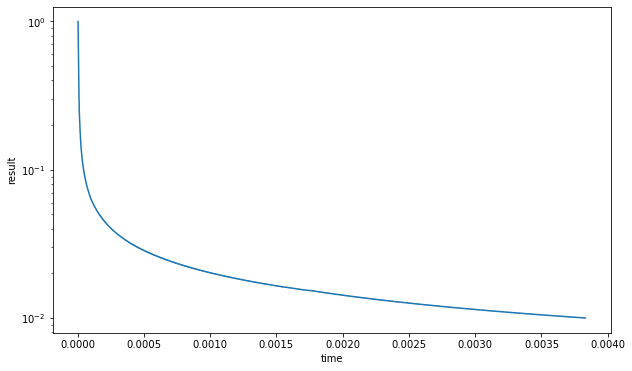

Default Time: 0.003831 seconds


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

## Set how many iterations each loop should run through
magnitude = 10**4

def default_inv_sqrt(magnitude):
    
    result = np.ones((magnitude))
    speed = np.ones((magnitude))
    start = time.time()
    
    for x in range (magnitude):
        result[x] = ((x+1)**-.5)
        end = time.time()
        speed[x] = end-start
    return speed, result

time_default, result = default_inv_sqrt(magnitude)

fig = plt.figure(figsize = (10,6))
plt.plot(time_default, result)
plt.xlabel('time')
plt.ylabel('result')
plt.yscale('log')
plt.show()

print("Default Time: %.6f seconds" %time_default[magnitude-1])

The default math library in python actually computes this very quickly.



### Implementation with Ctypes

The first way we can try to implement C in python is with the library `ctypes`. This library allows us to create native C types in python. The function lookups to translate between types actually slows the code down though :/

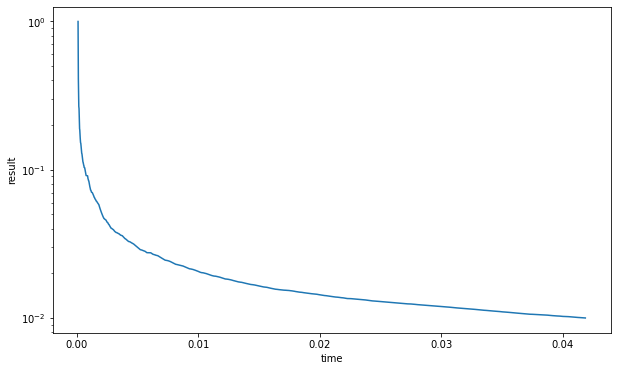

Ctypes Time: 0.041856 seconds


In [3]:
from ctypes import c_float, c_int32, cast, byref, POINTER

def ctypes_inv_sqrt(magnitude):
    
    result = np.ones((magnitude))
    speed = np.ones((magnitude))
    start = time.time()
    
    for x in range (magnitude):
        
        # This is the fast inverse square root algorithm described in the video
        threehalfs = 1.5 
        x2 = (x+1) * 0.5
        y = c_float(x+1)

        i = cast(byref(y), POINTER(c_int32)).contents.value
        i = c_int32(0x5f3759df - (i >> 1))
        y = cast(byref(i), POINTER(c_float)).contents.value

        y = y * (1.5 - (x2 * y * y))
        
    
        result[x] = y
        end = time.time()
        speed[x] = end-start
        
    return speed, result
    
time_ctypes, result_ctypes = ctypes_inv_sqrt(magnitude)

fig = plt.figure(figsize = (10,6))
plt.plot(time_ctypes, result_ctypes)
plt.xlabel('time')
plt.ylabel('result')
plt.yscale('log')
plt.show()

print("Ctypes Time: %.6f seconds" %time_ctypes[magnitude-1])


Using Ctypes is actually quite slower than default library, due to translating and lookups between different types. 

### Implementation with Python's Struct Module

This module is another way to turn numbers into a string of bytes so that the fast inverse square method can be implemented. 

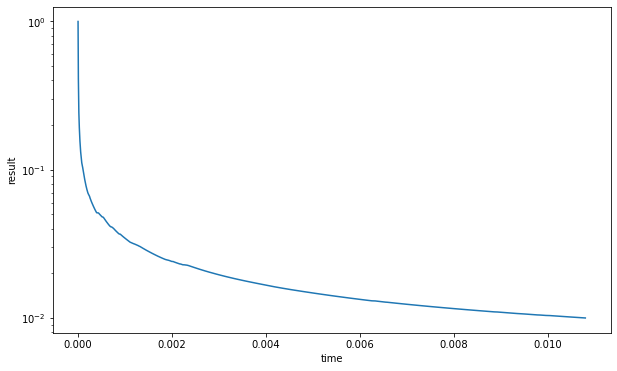

Struct Time: 0.010793 seconds


In [4]:
import struct 

def struct_inv_sqrt(magnitude):
    
    result = np.ones((magnitude))
    speed = np.ones((magnitude))
    start = time.time()
    
    for x in range (magnitude):
        
        threehalfs = 1.5
        x2 = (x+1) * 0.5
        y = x+1
    
        packed_y = struct.pack('f', y)       
        i = struct.unpack('i', packed_y)[0]  
        i = 0x5f3759df - (i >> 1)            
        packed_i = struct.pack('i', i)
        y = struct.unpack('f', packed_i)[0] 
    
        y = y * (threehalfs - (x2 * y * y))  
        
    
        result[x] = y
        end = time.time()
        speed[x] = end-start
        
    return speed, result

time_struct, result_struct = struct_inv_sqrt(magnitude)

fig = plt.figure(figsize = (10,6))
plt.plot(time_struct, result_struct)
plt.xlabel('time')
plt.ylabel('result')
plt.yscale('log')
plt.show()

print("Struct Time: %.6f seconds" %time_struct[magnitude-1])


This method is a bit faster than with Ctypes, but still slower than Python's default computation. 

### Comparison of Methods

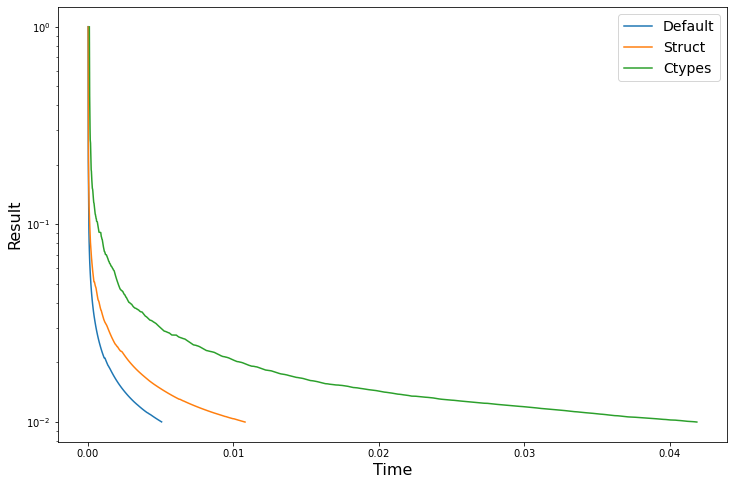

Default Time: 0.005058 seconds
Struct Time: 0.010793 seconds
Ctypes Time: 0.041856 seconds


In [5]:
fig = plt.figure(figsize = (12,8))
plt.plot(time_default, result, label = "Default")
plt.plot(time_struct, result_struct, label = "Struct")
plt.plot(time_ctypes, result_ctypes, label = "Ctypes")
plt.xlabel('Time', fontsize = 16)
plt.ylabel('Result', fontsize = 16)
plt.yscale('log')
plt.legend(loc="upper right", fontsize = 14)
plt.show()

print("Default Time: %.6f seconds" %time_default[magnitude-1])
print("Struct Time: %.6f seconds" %time_struct[magnitude-1])
print("Ctypes Time: %.6f seconds" %time_ctypes[magnitude-1])


The fastest method is the default python library due to the loss of speed when converting datatypes using other libraries to do byte calculations. If we want to really see a speed increase we will have to implement the code nativly in C. Please see the other Jupyter Notebook running a C kernal for the faster calculations.